Anamoly detection of Time-Series for Predictive Maintenance: Using Machine learning methods

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

Loading dataset from a directory

In [2]:
telemetry = pd.read_csv(r'D:\02_Work\04_projects\Predicitve maintenance\Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting-main\dataset\PdM_telemetry.csv')
errors = pd.read_csv(r'D:\02_Work\04_projects\Predicitve maintenance\Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting-main\dataset\PdM_errors.csv')
failures = pd.read_csv(r'D:\02_Work\04_projects\Predicitve maintenance\Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting-main\dataset\PdM_failures.csv')
maint = pd.read_csv(r'D:\02_Work\04_projects\Predicitve maintenance\Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting-main\dataset\PdM_maint.csv')
machines = pd.read_csv(r'D:\02_Work\04_projects\Predicitve maintenance\Predictive-Maintainence-using-Data-Analysis-and-Time-Series-Forecasting-main\dataset\PdM_machines.csv')

print("Data successfully loaded")

Data successfully loaded


Examining multiple machines.
Identifying which sensor data gives the most predictive failures.
Undestanding the temporal patterns in the sensor data.

Failures per machine:
machineID
1       7
2       4
3       5
4       6
5       7
       ..
96      5
97      8
98     16
99     19
100     3
Name: count, Length: 98, dtype: int64


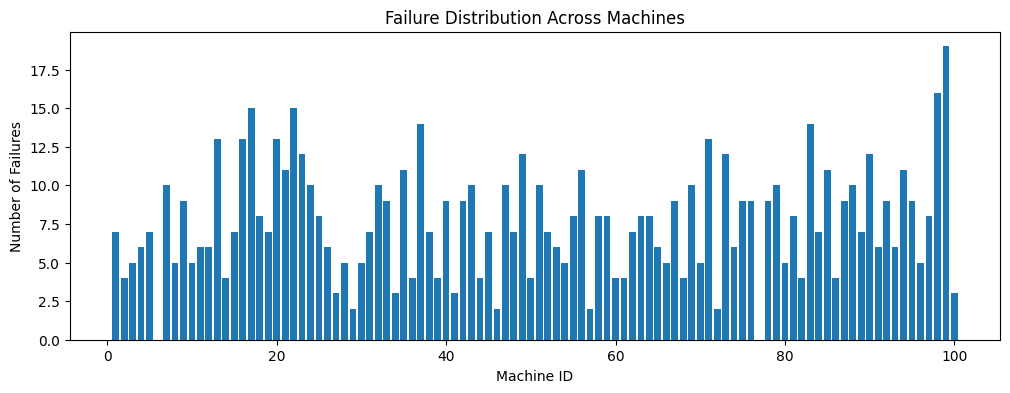

In [3]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])
errors['datetime'] = pd.to_datetime(errors['datetime'])

failure_counts = failures['machineID'].value_counts().sort_index()
print("Failures per machine:")
print(failure_counts)

plt.figure(figsize=(12, 4))
plt.bar(failure_counts.index, failure_counts.values)
plt.xlabel('Machine ID')
plt.ylabel('Number of Failures')
plt.title('Failure Distribution Across Machines')
plt.show()

Selecting machines with good history of sensor data for machine learning model training. So machines with few failures are selected. so machines with 2 -4 failures are selected for good reliability.

In [4]:
selected_machines = failure_counts[(failure_counts >= 2) & (failure_counts <= 4)].index.tolist()
print(f"Selected {len(selected_machines)} machines for analysis: {selected_machines}")

Selected 19 machines for analysis: [2, 14, 27, 29, 34, 36, 39, 41, 44, 46, 50, 57, 60, 61, 68, 72, 82, 86, 100]


In [5]:
df_sel = telemetry[telemetry['machineID'] == 14].reset_index(drop=True)
sel_fail = failures[failures['machineID'] == 14].reset_index(drop=True)
sel_err = errors[errors['machineID'] == 14].reset_index(drop=True)

print(f"\nMachine 14 statistics:")
print(f"Telemetry records: {len(df_sel)}")
print(f"Failures: {len(sel_fail)}")
print(f"Errors: {len(sel_err)}")
print(f"\nFailure dates:")
print(sel_fail[['datetime', 'failure']])


Machine 14 statistics:
Telemetry records: 8761
Failures: 4
Errors: 38

Failure dates:
             datetime failure
0 2015-01-31 06:00:00   comp2
1 2015-03-02 06:00:00   comp1
2 2015-07-15 06:00:00   comp1
3 2015-07-30 06:00:00   comp2


Visualization of sensor reading around a failure event for a specific machine. Around 10 days.

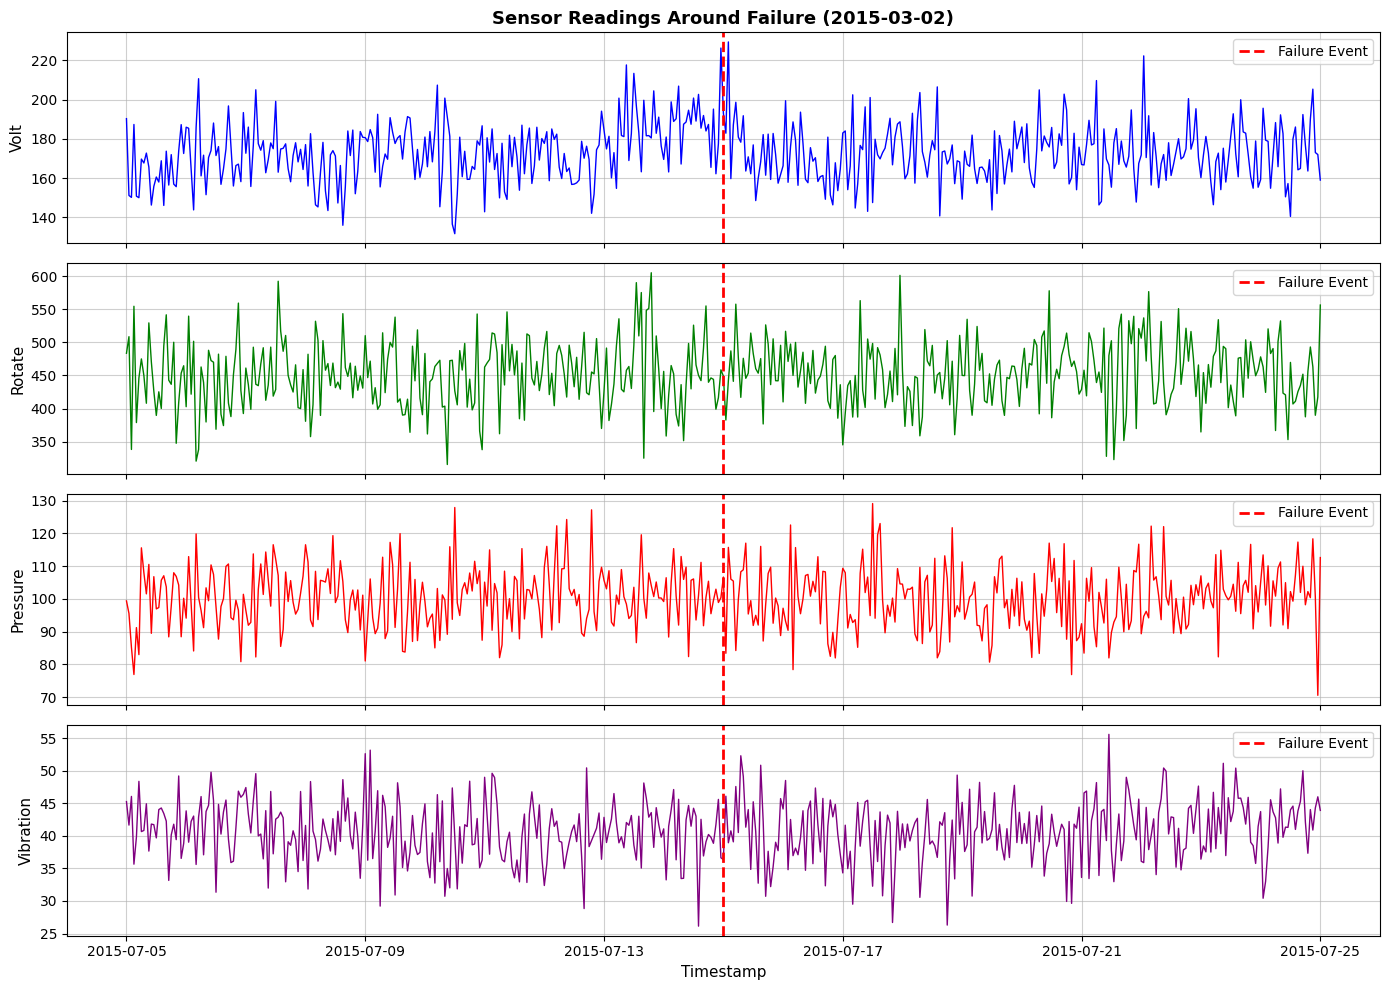

In [6]:
df_sel['datetime'] = pd.to_datetime(df_sel['datetime'])

# Selecting the failure on 2015-07-15
st = df_sel[df_sel['datetime'] == "2015-07-15"].index[0]

# Extracting 10 days before and after
window = df_sel.loc[st-(10*24):st+(10*24), :]

# Plot all 4 sensors in a single fingure
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

sensors = ['volt', 'rotate', 'pressure', 'vibration']
colors = ['blue', 'green', 'red', 'purple']

for ax, sensor, color in zip(axes, sensors, colors):
    ax.plot(window['datetime'], window[sensor], color=color, linewidth=1)
    ax.axvline(window.iloc[10*24]['datetime'], color='red', linestyle='--', linewidth=2, label='Failure Event')
    ax.set_ylabel(sensor.capitalize(), fontsize=11)
    ax.grid(alpha=0.6)
    ax.legend()

axes[-1].set_xlabel('Timestamp', fontsize=11)
axes[0].set_title('Sensor Readings Around Failure (2015-03-02)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

Anamoly detection using Machine learning methods:
1. Autoencoders.
Since there are multi sensor readings taken from each machine autoencoders can be used to combine these data. Also it is the best used method for non linear pattern recognition.

In [7]:
# Import necessary pytorch libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [8]:
# Data preparation
df_sel['datetime'] = pd.to_datetime(df_sel['datetime'])
df_sel = df_sel.sort_values('datetime')

failure_time = df_sel.loc[st, 'datetime']

# Extracting data 10 days prior and after failure occurance
window_df = df_sel.loc[st-(10*24):st+(10*24)].copy()

sensors = ['volt', 'rotate', 'pressure', 'vibration']

# Standardize the sensor data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(window_df[sensors])

x_tensor = torch.tensor(x_scaled, dtype= torch.float32)

# creating batches for training the autoencoders
dataset = TensorDataset(x_tensor)
loader = DataLoader(dataset, batch_size= 5, shuffle=True)

In [9]:
# Defining the architecture of the autoencoders
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder part 
        self.encoder = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3),
            nn.ReLU()
        )

        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(3, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 4)
         )
        
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training the autoencoder
train_losses = []
epochs = 200
model.train()

for epoch in range(epochs):
    epoch_loss = 0
    for batch in loader:
        batch_x = batch[0]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    avg_loss = epoch_loss
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs}, loss : {epoch_loss:.4f}")

Epoch 1/200, loss : 98.7241
Epoch 2/200, loss : 91.5769
Epoch 3/200, loss : 77.2114
Epoch 4/200, loss : 61.1019
Epoch 5/200, loss : 53.9218
Epoch 6/200, loss : 52.0526
Epoch 7/200, loss : 50.8092
Epoch 8/200, loss : 50.4024
Epoch 9/200, loss : 48.3617
Epoch 10/200, loss : 46.0387
Epoch 11/200, loss : 42.2594
Epoch 12/200, loss : 38.9802
Epoch 13/200, loss : 35.3344
Epoch 14/200, loss : 34.0979
Epoch 15/200, loss : 32.8797
Epoch 16/200, loss : 31.6610
Epoch 17/200, loss : 30.0949
Epoch 18/200, loss : 29.9745
Epoch 19/200, loss : 28.7643
Epoch 20/200, loss : 29.7097
Epoch 21/200, loss : 28.5920
Epoch 22/200, loss : 28.6604
Epoch 23/200, loss : 27.4986
Epoch 24/200, loss : 28.3460
Epoch 25/200, loss : 28.2223
Epoch 26/200, loss : 27.5552
Epoch 27/200, loss : 27.8115
Epoch 28/200, loss : 27.5988
Epoch 29/200, loss : 26.5738
Epoch 30/200, loss : 27.1878
Epoch 31/200, loss : 26.8643
Epoch 32/200, loss : 26.7875
Epoch 33/200, loss : 26.2239
Epoch 34/200, loss : 26.8311
Epoch 35/200, loss : 26

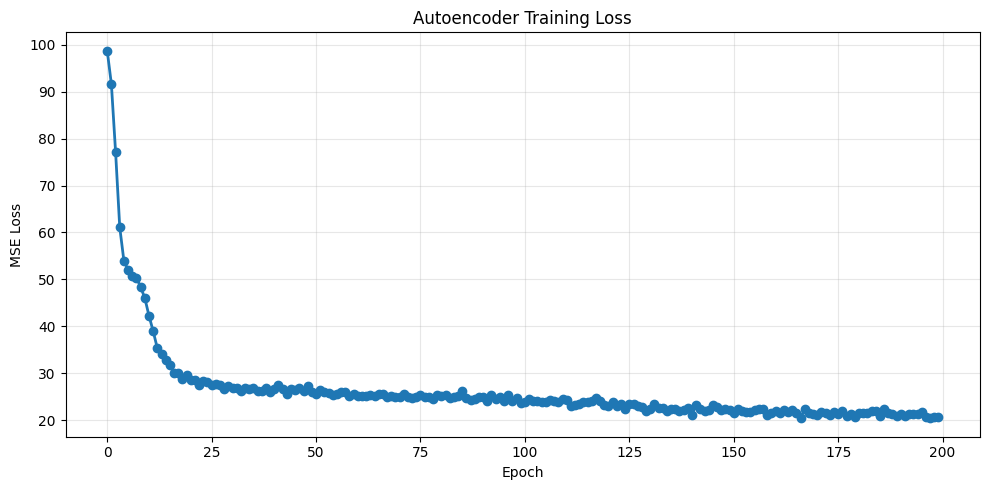

In [11]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, marker='o', linewidth=2)
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
# Calculating the reconstruction error
model.eval()
with torch.no_grad():
    reconstructed = model(x_tensor).numpy()

recon_error = np.mean((x_scaled- reconstructed)**2, axis =1)
window_df['ae_error'] = recon_error

# Calculating the threshold
threshold = window_df['ae_error'].mean() + 3 * window_df['ae_error'].std()
window_df['ae_anamoly'] = window_df['ae_error']>threshold

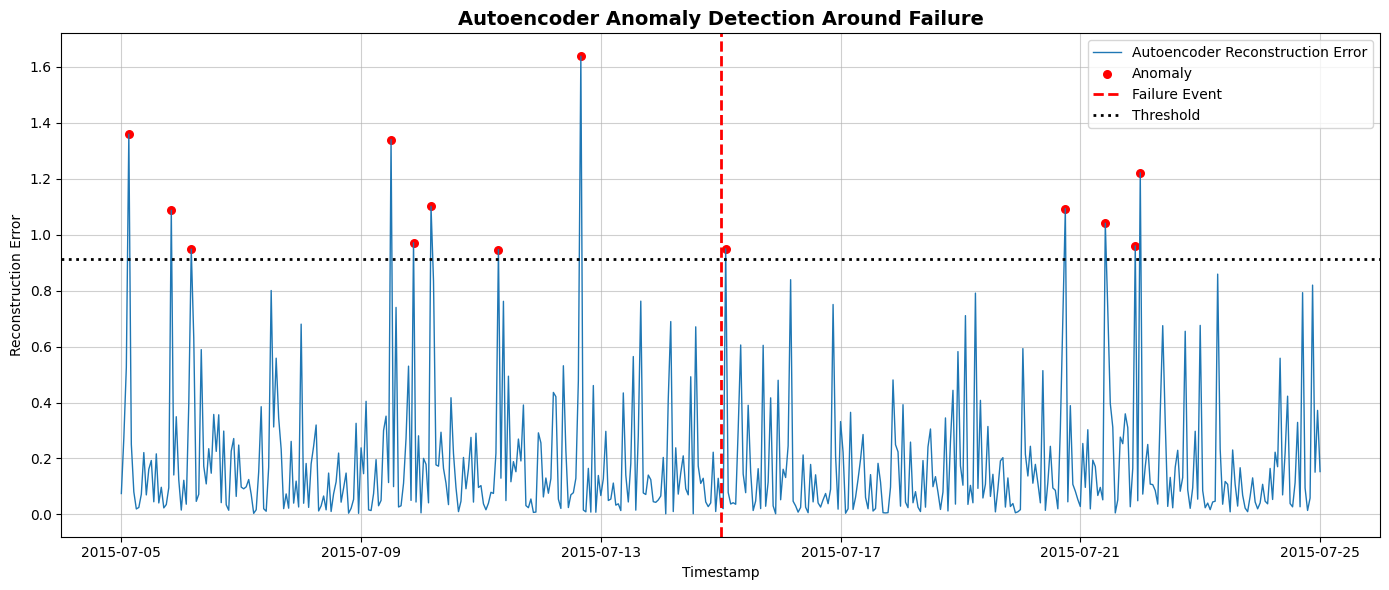

In [14]:
# Plotting the anamolies
plt.figure(figsize=(14,6))

plt.plot(window_df['datetime'], window_df['ae_error'], label='Autoencoder Reconstruction Error', linewidth=1)

# Highlight anomalies
anoms = window_df[window_df['ae_anamoly']]
plt.scatter(anoms['datetime'], anoms['ae_error'], color='red', s=30, label='Anomaly')

# Failure event line
plt.axvline(failure_time, color='red', linestyle='--', linewidth=2, label='Failure Event')

# Threshold line
plt.axhline(threshold, color='black', linestyle=':',linewidth=2, label='Threshold')

plt.title("Autoencoder Anomaly Detection Around Failure",fontsize=14, fontweight='bold')
plt.xlabel("Timestamp")
plt.ylabel("Reconstruction Error")
plt.grid(alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
